In [1]:
# Run Number
num = 30       # define the number label of the run here, this will create a new folder for the outputs
newpath = r'C:\Users\Tomas\Desktop\Martin Group\ubermag_images\test_' # create a new path based on where you want the output
newpath = newpath + str(num) # the new path will have the name newpath{num}

In [2]:
# Import packages
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
import pandas as pd

# Material properties
## Nickel
A_ex = 15e-12       # exchange constant
L1 = -24            # Strain constant 1 (<100> cubic direction) in ppm
L2 = -48            # Strain constant 2 (<111> cubic direction) in ppm
K1 = -0.5e5/1.257e2       # anisotropy constant 1 J/m^3: K1 < 0 indicates hard axis, K1 > 0 easy axis
K2 = -0.2e5/1.257e2       # anisotropy constant 2 J/m^3, not callable in this code
u_11 = (1, 0, 0)    # K1 axis one: should be hard axis if K1 < 0, easy axis if K1 > 0
u_12 = (0, 1, 0)    # K1 axis 2: just needs to be orthogonal to u_11
damping = 0.045         # damping constant (alpha)
Ms = 4.8e5          # magnetization saturation (A/m)
## Metglas
A_ex = 15e-12       # exchange constant
L1 = 27            # Strain constant 1 (<100> cubic direction) in ppm
L2 = 27            # Strain constant 2 (<111> cubic direction) in ppm
K1 = -0.5e5/1.257e2       # anisotropy constant 1 J/m^3: K1 < 0 indicates hard axis, K1 > 0 easy axis
K2 = -0.2e5/1.257e2       # anisotropy constant 2 J/m^3, not callable in this code
u_11 = (1, 0, 0)    # K1 axis one: should be hard axis if K1 < 0, easy axis if K1 > 0
u_12 = (0, 1, 0)    # K1 axis 2: just needs to be orthogonal to u_11
damping = 0.045         # damping constant (alpha)
Ms = 1.27e5          # magnetization saturation (A/m)

In [3]:
# Time setup
tfinal = .5          # Final time of simulation
tstep = 5e-6        # timestep in seconds
ntot = int(tfinal/tstep)         # total number of time steps
# Material properties
A_ex = 15e-12       # exchange constant
L1 = -24            # Strain constant 1 (<100> cubic direction) in ppm
L2 = -48            # Strain constant 2 (<111> cubic direction) in ppm
K1 = -0.5e5/1.257e2       # anisotropy constant 1 J/m^3: K1 < 0 indicates hard axis, K1 > 0 easy axis
K2 = -0.2e5/1.257e2       # anisotropy constant 2 J/m^3, not callable in this code 
u_11 = (1, 0, 0)    # K1 axis one: will be hard axis if K1 < 0, easy axis if K1 > 0
u_12 = (0, 1, 0)    # K1 axis 2: just needs to be orthogonal to u_11
damping = .3         # damping constant (alpha)
Ms = 5.4e5          # magnetization saturation (A/m)
# Alternating source properties
source_freq = 100   # source frequency (Hz)
H_app = (0, 0, 10e3)# applied field (A/m) in  (x,y,z) coordinates
source_type = 'sin' # waveform of source
# Strain measurement axis
B = np.array([0,0,1]) # ([x,y,z])
# Geometry of object
r = 1e-9            # material radius, m (this is only a radius if making a cylinder)
L = 2*r            # material length, m
d = 1e-9            # cell dimensions, m

In [4]:
# Create a new folder with name "[newpath]"
if not os.path.exists(newpath):
    os.makedirs(newpath)


In [5]:
# Create a new file with all parameters written into it
newfile = newpath + r'\parameters.txt'
f = open(newfile,"w")
f.write(
f"""
# Run Number
num = {str(num)}                   # define the number label of the run here, this will create a new folder for the outputs
# Time setup
tfinal = {str(tfinal)}             # Final time of simulation in seconds
tstep = {str(tstep)}               # timestep in seconds
ntot = {str(ntot)}                 # total number of time steps
# Material properties
A_ex = {str(A_ex)}                 # exchange constant
L1 = {str(L1)}                     # Strain constant 1 in ppm
L2 = {str(L2)}                     # Strain constant 2 in ppm
K1 = {str(K1)}                     # anisotropy constant 1
K2 = {str(K2)}                     # anisotropy constant 2
u_easy = {str(u_11)}               # axis 1 for K1
u_hard = {str(u_12)}               # axis 2 for K1
damping = {str(damping)}           # damping constant (alpha)
Ms = {str(Ms)}                     # magnetization saturation (A/m)
# Alternating source properties
source_freq = {str(source_freq)}   # source frequency (Hz)
H_app = {str(H_app)}               # applied field (A/m)
source_type = {source_type}        # waveform of source
# Strain measurement axis
B = {str(B)}
# Geometry of object
r = {str(r)}                       # material radius (m)
L = {str(L)}                       # material length (m)
d = {str(d)}                       # cell dimensions (m)
"""
)

f.close()

In [6]:
# Define initial mesh
p1 = (-r, -r, -L/2)                        # Starting point
p2 = (r, r, L/2)                           # Ending point
cell = (d, d, d)                           # Cell size
region = df.Region(p1=p1, p2=p2)           # Define the region
mesh = df.Mesh(region=region, cell=cell)   # Create the mesh

In [7]:
# Initial mesh
mesh.k3d()

Output()

In [8]:
# Define the system name
system = mm.System(name='time_dependent_field')

# Define system energy
system.energy = (mm.Zeeman(H=H_app, func=source_type, f=source_freq, t0=0) # external field
                + mm.Demag()                                               # demagnetization energy
                + mm.Exchange(A=A_ex)                                      # exchange energy
                + mm.CubicAnisotropy(K=K1, u1=u_11, u2=u_12))              # cubic anisotropy, can be changed to uniaxial
                                                                            # see OOMMF documentation for instructions

# Define system dynamics with precession and damping term
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + mm.Damping(alpha=damping)

In [9]:
def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape,
    Ms inside cylinder.

    Cylinder radius is r.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < r:
        return Ms
    else:
        return 0

In [10]:
def cube_fun(pos):
    """Function to set values for a 2x2x2 cube such that they demagnetize the cube

    """
    i_states = {'state_1':(1,0,1),'state_2':(-1,0,-1),'state_3':(0,1,0),'state_4':(0,-1,0)}
    x, y, z = pos
    if x > 0 and y > 0 and z > 0: 
        return i_states['state_1']
    if x > 0 and y < 0 and z > 0: 
        return i_states['state_3']
    if x < 0 and y < 0 and z > 0:
        return i_states['state_2']
    if x < 0 and y > 0 and z > 0:
        return i_states['state_4']
    if x > 0 and y > 0 and z < 0:
        return i_states['state_3']
    if x > 0 and y < 0 and z < 0:
        return i_states['state_2']
    if x < 0 and y < 0 and z < 0:
        return i_states['state_4']
    if x < 0 and y > 0 and z < 0:
        return i_states['state_1']


In [11]:
# Define the field element
system.m = df.Field(mesh, dim=3, value=cube_fun, norm=Ms) # cube_fun is called and the value of each vector is Ms

# Assign a random value of 4 defined states to each cell to represent the different domains.

i_states = {'state_1':(1,0,1),'state_2':(-1,0,-1),'state_3':(0,1,-1),'state_4':(0,-1,1)}
n = len(system.m.array[0,0])
i=0
for array_mass in system.m.array:
    j=0
    for array_element in system.m.array[i]:
        array_element = np.array(random.choices(list(i_states.values()),k=n))
        system.m.array[i,j] = array_element
        j+=1
    i+=1
    

i_states = {'state_1':(1,0,1),'state_2':(-1,0,-1),'state_3':(0,1,0),'state_4':(0,-1,0)}
# Top Layer
system.m.array[0,0,0] = np.array(i_states['state_1'])
system.m.array[0,1,0] = np.array(i_states['state_4'])
system.m.array[1,0,0] = np.array(i_states['state_3'])
system.m.array[1,1,0] = np.array(i_states['state_2'])
# Bottom Layer
system.m.array[0,0,1] = np.array(i_states['state_2'])
system.m.array[0,1,1] = np.array(i_states['state_3'])
system.m.array[1,0,1] = np.array(i_states['state_1'])
system.m.array[1,1,1] = np.array(i_states['state_4'])


system.m.array

In [12]:
# Redefine the field element to define the cylindrical shape again
#system.m = df.Field(mesh, dim=3, value = system.m.array, norm=Ms_fun)
#system.m = df.Field(mesh, dim=3, value = system.m.array, norm=Ms)

In [13]:
# Show the cylinder/wire shape
system.m.norm.k3d.nonzero()

Output()

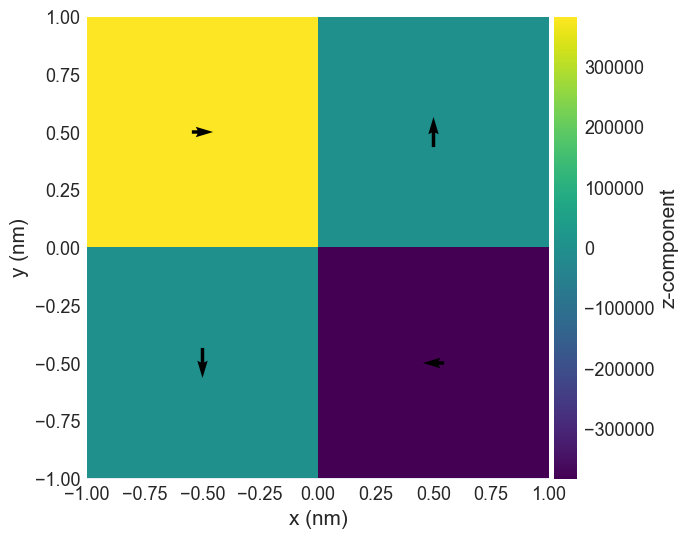

In [14]:
# Plot the initial magnetization of one cross section that is one cell thick
system.m.plane('z').mpl()
plt.savefig(newpath+r'\initial_mag.jpg')

In [ ]:
ev = mc.RungeKuttaEvolver(min_timestep=tstep) # Define the evolver as Runge Kutta method
td = mc.TimeDriver(evolver=ev)                # Setup time driver with evolver input
td.drive(system, n=ntot, t=tfinal, verbose=2) # Drive the system

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/99999 files written [00:00]

In [ ]:
# td._allowed_attributes

In [ ]:
system.table.data

In [ ]:
# Plot the external magnetic field 
system.table.mpl(y=['Bx_zeeman', 'By_zeeman', 'Bz_zeeman'])
plt.legend(['$H_x$','$H_y$','$H_z$'])
plt.title('External Field')
plt.ylabel('Field Magnitude (kA/m)')
plt.savefig(newpath+r'\mag_field.jpg')

In [ ]:
# Plot the normalized magnetization
system.table.mpl(y=['mx', 'my', 'mz'])
plt.legend(['$m_x$','$m_y$','$m_z$'])
plt.ylabel('m')
plt.title('Normalized Magnetization')
plt.savefig(newpath+r'\magnetization.jpg')

In [ ]:
# Assign magnetization data to x,y,z variables.
mx = system.table.data['mx']
my = system.table.data['my']
mz = system.table.data['mz']

In [ ]:
# Normalize the strain measurement axis and separate into x,y,z.
B = B/np.linalg.norm(B)
Bx = B[0]
By = B[1]
Bz = B[2]

In [ ]:
# Strain calculation for cubic anisotropy
ll = 3/2*L1*(mx**2*Bx**2+my**2*By**2+mz**2*Bz**2-1/3)+3*L2*(mx*my*Bx*By+my*mz*By*Bz+mz*mx*Bz*Bx)

# Calculate strain rate by taking a numerical time derivative
ll_rate = [0]
for i in range(0,len(ll)-1):
    ll_rate_i = (ll[i+1]-ll[i])/(system.table.data['t'][1]-system.table.data['t'][0])
    ll_rate.append(ll_rate_i)



In [ ]:
# Define a new column in the data for the strain
system.table.data['ll'] = ll
system.table.data['ll_rate'] = ll_rate

In [ ]:
# Plot the strain response
system.table.mpl(y=['ll'])
plt.legend().remove()
plt.title('Model Strain Response')
plt.ylabel(r'$\lambda$ (ppm)')
plt.savefig(newpath+r'\strain.jpg')

In [ ]:
# Plot the strain response zoomed, change these if you'd like to see the small scale oscillations
system.table.mpl(y=['ll'])
plt.legend().remove()
plt.title('Model Strain Response')
plt.ylabel(r'$\lambda$ (ppm)')
plt.xlim([28,30])
plt.ylim([7.5875,7.595])
plt.savefig(newpath+r'\strain_zoom.jpg')

In [ ]:
# Plot strain rate
system.table.mpl(y=['ll_rate'])
plt.legend().remove()
plt.title('Model Strain Rate')
plt.ylabel(r'$\frac{d \lambda}{dt}$ (ppm/s)')
plt.savefig(newpath+r'\strain_rate.jpg')

In [ ]:
# Zoom in on the strain rate plot here
system.table.mpl(y=['ll_rate'])
plt.legend().remove()
plt.title('Model Strain Rate')
plt.ylabel(r'$\frac{d \lambda}{dt}$ (ppm/s)')
plt.ylim([-500,500])
plt.xlim([29.8,30])
plt.savefig(newpath+r'\strain_rate_zoom.jpg')

In [ ]:
# FFT setup for strain
from scipy.fft import fft, fftfreq
T = system.table.data['t'][1]-system.table.data['t'][0]
y = np.array(system.table.data['ll'])

fft_ll = fft(y)
N = len(y)
x = np.linspace(0.0, N*T, N, endpoint=False)

xf = fftfreq(N, T)[:N//2]

PS = 2*np.abs(fft_ll[0:N//2])/N

In [ ]:
# Plot the amplitude spectrum of strain
plt.plot(xf, PS)
plt.xlabel('f (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,5*source_freq)
plt.ylim(0,0.00001)
plt.grid()
plt.title('Model Amplitude Spectrum')
plt.savefig(newpath+r'\amp_spectrum.jpg')

In [ ]:
# Export Data to the folder specified
system.table.data.to_csv(newpath+r'/data.csv')
df = pd.DataFrame({'frequency':xf, 'Amplitude':PS})
df.to_csv(newpath+r'/Power_Spectrum.csv')

In [ ]:
# FFT setup for strain after time t_init
from scipy.fft import fft, fftfreq
t_init = 0.08
T = system.table.data['t'][1]-system.table.data['t'][0]
y = np.array(system.table.data['ll'][system.table.data['t']>t_init])

fft_ll = fft(y)
N = len(fft_ll)
x = np.linspace(0.0, N*T, N, endpoint=False)

xf = fftfreq(N, T)[:N//2]

PS = 2*np.abs(fft_ll[0:N//2])/N

In [ ]:
# Plot the amplitude spectrum of the strain after time t_init
plt.plot(xf, PS)
plt.grid()
plt.xlabel('f (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,5*source_freq)
plt.ylim(0,.2)
plt.title('Filtered Model Amplitude Spectrum')
plt.savefig(newpath+r'\amp_spectrum_filtered.jpg')

In [ ]:
# FFT setup for strain rate after time t_init
from scipy.fft import fft, fftfreq
t_init2 = 0.08
T = system.table.data['t'][1]-system.table.data['t'][0]
y = np.array(system.table.data['ll_rate'][system.table.data['t']>t_init2])

fft_ll = fft(y)
N = len(fft_ll)
x = np.linspace(0.0, N*T, N, endpoint=False)

xf_rate = fftfreq(N, T)[:N//2]

PS_rate = 2*np.abs(fft_ll[0:N//2])/N

In [ ]:
# Plot the amplitude spectrum of the strain rate
plt.plot(xf_rate, PS_rate)
plt.xlabel('f (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,5*source_freq)
plt.ylim(0,0.01)
plt.grid()
plt.title('Model Strain Rate Amplitude Spectrum')
plt.savefig(newpath+r'\amp_spectrum_filtered_strain_rate.jpg')

In [ ]:
# save the amplitude spectrum data
df_rate = pd.DataFrame({'frequency':xf_rate, 'Amplitude':PS_rate})
df_rate.to_csv(newpath+r'/Rate_Power_Spectrum.csv')